In [67]:
from cmdstanpy import CmdStanModel

from seaborn import jointplot
import arviz as az
import numpy as np
import scipy.stats as stats

import matplotlib.pyplot as plt
import pandas as pd

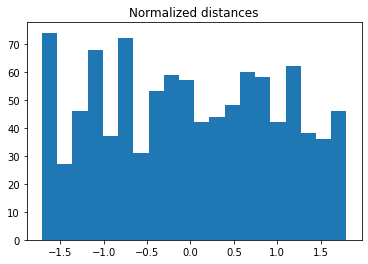

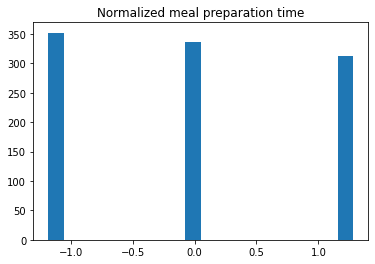

9.305280999999999
26.747


In [68]:
df = pd.read_csv('delivery_time_data.csv', delimiter=';', decimal=',')

df = df[df["Road distances [km]"] < 17.5]

# display(df.describe())

train_df = pd.DataFrame(df.iloc[:1000, :])
# normalized distance
train_df["Normalized distances"] = (train_df["Road distances [km]"] - train_df["Road distances [km]"].mean()) / train_df["Road distances [km]"].std()

# normalized distance
train_df["Normalized mealprep"] = (train_df["Meal_preparation_time"] - train_df["Meal_preparation_time"].mean()) / train_df["Meal_preparation_time"].std()

# train_df = train_df[train_df["Mean speed"] < 1.7]
plt.hist(train_df["Normalized distances"], bins=20)
plt.title("Normalized distances")
plt.show()

plt.hist(train_df["Normalized mealprep"], bins=20)
plt.title("Normalized meal preparation time")
plt.show()

print(train_df["Road distances [km]"].mean())
print(train_df["Time_taken(min)"].mean())

# display(train_df["Road_traffic_density"].value_counts())
# plt.title("Count of density type")
# plt.show()

# train_df["Mean speed"].describe()
# train_df["Time_taken(min)"].describe()
# train_df.head()

road_density_map = {'Jam ':1, 'High ':2, 'Medium ':3, 'Low ':4}

train_df["Road_traffic_density"] = train_df["Road_traffic_density"].apply(lambda x: road_density_map[x])


# PPC CHECKS

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start processing
chain 1 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.


count    1000.000000
mean        1.879422
std         0.593195
min         0.719856
25%         1.380720
50%         1.882990
75%         2.384635
max         3.001520
Name: 0, dtype: float64

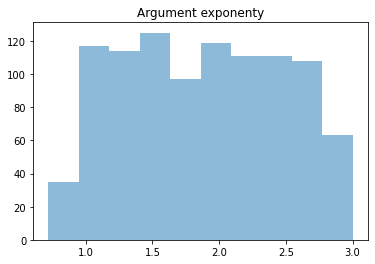

count    1000.000000
mean        7.768166
std         4.511996
min         2.054140
25%         3.977770
50%         6.573160
75%        10.855150
max        20.116100
Name: 0, dtype: float64

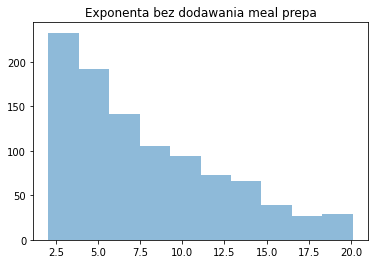

count    1000.000000
mean       23.703912
std        18.006057
min         3.589080
25%        11.069450
50%        17.995550
75%        31.028275
max        95.552300
Name: 0, dtype: float64

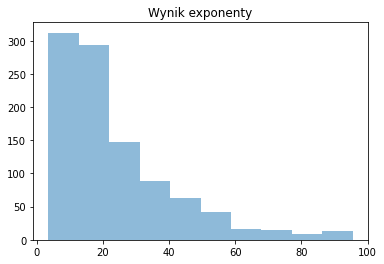

Odchylenie =  [[1.54846]]


count    1000.000000
mean      369.419398
std       599.884988
min         5.372350
25%        51.103400
50%       135.061000
75%       401.527250
max      3807.860000
Name: 0, dtype: float64

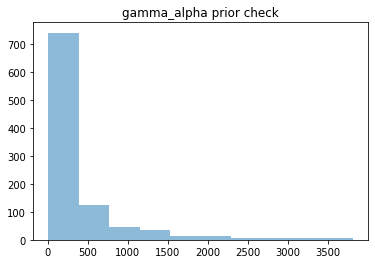

count    1000.000000
mean        9.885964
std         7.509615
min         1.496860
25%         4.616623
50%         7.505250
75%        12.940675
max        39.851100
Name: 0, dtype: float64

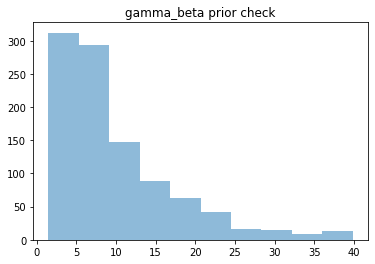

count    1000.000000
mean       23.711499
std        18.087611
min         1.670490
25%        10.867075
50%        18.235350
75%        31.088550
max        96.943600
Name: 0, dtype: float64


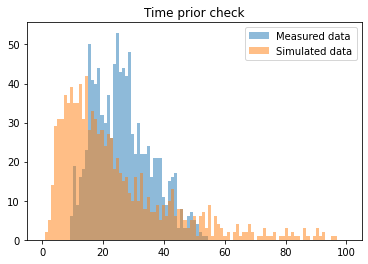

distance_coef    distance_coeff
0        0.127082


In [69]:
model_ppc=CmdStanModel(stan_file='basic_ppc.stan')

sim=model_ppc.sample(data={"N": len(train_df), "distance": train_df["Road distances [km]"].values,"meal_preparation_time": train_df["Meal_preparation_time"].values,"traffic_level" :train_df["Road_traffic_density"].values}, 
                     iter_sampling=1,
                     iter_warmup=0, 
                     chains=1, 
                     fixed_param=True,
                     seed=29042020)
ppc_df = sim.draws_pd()

bins = np.linspace(0,100,100)

# speed_bins = np.linspace(0,2.5,100)
# speed = ppc_df.filter(regex="speed.*")
# plt.hist(train_df["Mean speed"],bins=speed_bins ,alpha=0.5, label="Measured data")
# plt.hist(speed.values.flatten(),bins=speed_bins, alpha=0.5, label="Simulated data")
# plt.title("Speed prior check")
# plt.legend()
# plt.show()

mean_for_gamma = ppc_df.filter(regex="temp1.*")

delivery = ppc_df.filter(regex="delivery_time.*")
display(mean_for_gamma.iloc[0,:].describe())
# delivery.iloc[:,:].apply(pd.DataFrame.describe, axis=1)
# delivery['value'].describe()
# display(speed.loc[0,:].min())
plt.hist(mean_for_gamma.values.flatten(), alpha=0.5, label="Mu")
plt.title("Argument exponenty")
plt.show()

mean_for_gamma = ppc_df.filter(regex="temp2.*")

delivery = ppc_df.filter(regex="delivery_time.*")
display(mean_for_gamma.iloc[0,:].describe())
# delivery.iloc[:,:].apply(pd.DataFrame.describe, axis=1)
# delivery['value'].describe()
# display(speed.loc[0,:].min())
plt.hist(mean_for_gamma.values.flatten(), alpha=0.5, label="Mu")
plt.title("Exponenta bez dodawania meal prepa")
plt.show()

mean_for_gamma1 = ppc_df.filter(regex="mu.*")

# delivery = ppc_df.filter(regex="delivery_time.*")
display(mean_for_gamma1.iloc[0,:].describe())
# delivery.iloc[:,:].apply(pd.DataFrame.describe, axis=1)
# delivery['value'].describe()
# display(speed.loc[0,:].min())
plt.hist(mean_for_gamma1.values.flatten(), alpha=0.5, label="Mu")
plt.title("Wynik exponenty")
plt.show()

sigma = ppc_df.filter(regex="sigma.*")
print(f"Odchylenie =  {sigma.values}")

mean_for_gamma2 = ppc_df.filter(regex="gamma_alpha.*")
# delivery = ppc_df.filter(regex="delivery_time.*")
display(mean_for_gamma2.iloc[0,:].describe())
# delivery.iloc[:,:].apply(pd.DataFrame.describe, axis=1)
# delivery['value'].describe()
# display(speed.loc[0,:].min())
plt.hist(mean_for_gamma2.values.flatten(), alpha=0.5, label="Mu")
plt.title("gamma_alpha prior check")
plt.show()

mean_for_gamma3 = ppc_df.filter(regex="gamma_beta.*")
# delivery = ppc_df.filter(regex="delivery_time.*")
display(mean_for_gamma3.iloc[0,:].describe())
# delivery.iloc[:,:].apply(pd.DataFrame.describe, axis=1)
# delivery['value'].describe()
# display(speed.loc[0,:].min())
plt.hist(mean_for_gamma3.values.flatten(), alpha=0.5, label="Mu")
plt.title("gamma_beta prior check")
plt.show()

print(delivery.iloc[0,:].describe())
plt.hist(train_df["Time_taken(min)"],bins=bins ,alpha=0.5, label="Measured data")
plt.hist(delivery.values.flatten(),bins=bins, alpha=0.5, label="Simulated data")
plt.title("Time prior check")
plt.legend()
plt.show()


print(f"distance_coef {ppc_df.filter(regex='distance_coeff.*')}")


In [70]:
data={"N": len(train_df), "distance": train_df["Road distances [km]"].values,"meal_preparation_time": train_df["Meal_preparation_time"].values,"traffic_level" :train_df["Road_traffic_density"].values}

display(train_df["Road distances [km]"].describe())
display(train_df["Meal_preparation_time"].describe())
display(train_df["Road_traffic_density"].value_counts())

count    1000.000000
mean        9.305281
std         4.524166
min         1.572000
25%         5.525500
50%         9.228000
75%        13.171000
max        17.433000
Name: Road distances [km], dtype: float64

count    1000.000000
mean        9.800000
std         4.071434
min         5.000000
25%         5.000000
50%        10.000000
75%        15.000000
max        15.000000
Name: Meal_preparation_time, dtype: float64

4    343
1    324
3    234
2     99
Name: Road_traffic_density, dtype: int64

## Model fit

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▎      | 00:00 Status





chain 1 |██████████| 00:00 Sampling completed
chain 2 |██████████| 00:00 Sampling completed                    
chain 3 |██████████| 00:00 Sampling completed                    
chain 4 |██████████| 00:00 Sampling completed                    


INFO:cmdstanpy:CmdStan done processing.


,lp__,accept_stat__,distance_coeff_raw,traffic_level_coeff[1],traffic_level_coeff[2],traffic_level_coeff[3],traffic_level_coeff[4],meal_prep_coeff,sigma,distance_coeff,...,exp_argument[991],exp_argument[992],exp_argument[993],exp_argument[994],exp_argument[995],exp_argument[996],exp_argument[997],exp_argument[998],exp_argument[999],exp_argument[1000]
0,0.0,0.0,0.190318,0.08263,0.047068,0.032672,0.060946,0.036722,1.28087,0.190318,...,1.0439,2.58294,0.647456,3.18303,1.20598,2.01527,2.21092,0.701685,3.76724,0.825343
1,0.0,0.0,0.190318,0.08263,0.047068,0.032672,0.060946,0.036722,1.28087,0.190318,...,1.0439,2.58294,0.647456,3.18303,1.20598,2.01527,2.21092,0.701685,3.76724,0.825343
2,0.0,0.0,0.190318,0.08263,0.047068,0.032672,0.060946,0.036722,1.28087,0.190318,...,1.0439,2.58294,0.647456,3.18303,1.20598,2.01527,2.21092,0.701685,3.76724,0.825343
3,0.0,0.0,0.190318,0.08263,0.047068,0.032672,0.060946,0.036722,1.28087,0.190318,...,1.0439,2.58294,0.647456,3.18303,1.20598,2.01527,2.21092,0.701685,3.76724,0.825343
4,0.0,0.0,0.190318,0.08263,0.047068,0.032672,0.060946,0.036722,1.28087,0.190318,...,1.0439,2.58294,0.647456,3.18303,1.20598,2.01527,2.21092,0.701685,3.76724,0.825343


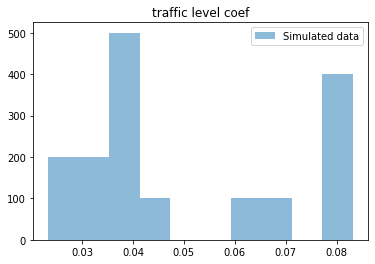

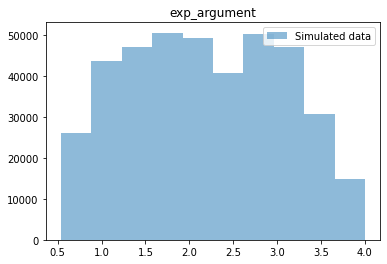

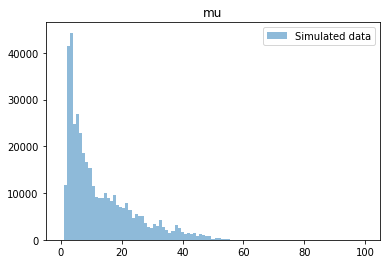

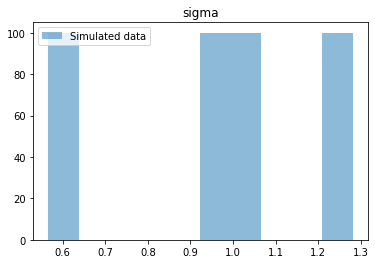

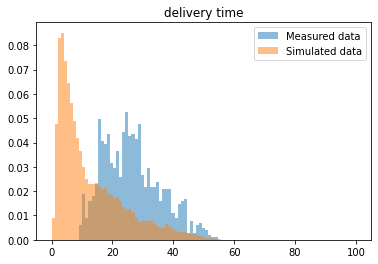

In [71]:
basic_fit=CmdStanModel(stan_file='basic_fit.stan')

basic_sample=basic_fit.sample(data={"N": len(train_df), 
                                    "distance": train_df["Road distances [km]"].values,
                                    "meal_preparation_time": train_df["Meal_preparation_time"].values, 
                                    "delivery_times": train_df["Time_taken(min)"].values, 
                                    "traffic_level" :train_df["Road_traffic_density"].values},
                              iter_sampling=100,
                              chains=4,
                              iter_warmup=0,
                              fixed_param=True,
                         )


df_fit = basic_sample.draws_pd()
display(df_fit.head())


traffib_level = df_fit.filter(regex="traffic_level_coef.*")
# df_fit.iloc[:, 8:]
# plt.hist(train_df["Time_taken(min)"], bins=bins, alpha=0.5, label="Measured data")
plt.hist(traffib_level.values.flatten(), alpha=0.5, label="Simulated data")
plt.title("traffic level coef")
plt.legend()
plt.show()

epx_argument = df_fit.filter(regex="exp_argument.*")
# df_fit.iloc[:, 8:]
# plt.hist(train_df["Time_taken(min)"], bins=bins, alpha=0.5, label="Measured data")
plt.hist(epx_argument.values.flatten(), alpha=0.5, label="Simulated data")
plt.title("exp_argument")
plt.legend()
plt.show()

mu = df_fit.filter(regex="mu.*")
# df_fit.iloc[:, 8:]
# plt.hist(train_df["Time_taken(min)"], bins=bins, alpha=0.5, label="Measured data")
plt.hist(mu.values.flatten(),bins=bins, alpha=0.5, label="Simulated data")
plt.title("mu")
plt.legend()
plt.show()

# travel_time = df_fit.filter(regex="travel_time.*")
# # df_fit.iloc[:, 8:]
# # plt.hist(train_df["Time_taken(min)"], bins=bins, alpha=0.5, label="Measured data")
# plt.hist(travel_time.values.flatten(),bins=np.linspace(0,100,100), alpha=0.5, label="Simulated data")
# plt.title("travel time")
# plt.legend()
# plt.show()

sigma = df_fit.filter(regex="sigma.*")
# df_fit.iloc[:, 8:]
# plt.hist(train_df["Time_taken(min)"], bins=bins, alpha=0.5, label="Measured data")
plt.hist(sigma.values.flatten(), alpha=0.5, label="Simulated data")
plt.title("sigma")
plt.legend()
plt.show()



delivery_fit = df_fit.filter(regex="delivery_time.*")
# df_fit.iloc[:, 8:]
plt.hist(train_df["Time_taken(min)"], bins=bins,density=True, alpha=0.5, label="Measured data")
plt.hist(delivery_fit.values.flatten(),bins=bins,density=True, alpha=0.5, label="Simulated data")
plt.title("delivery time")
plt.legend()
plt.show()

# print(f"meal_prep_ceof {df_fit.filter(regex='meal_prep_coef.*')}")
# print(f"distance_coef {df_fit.filter(regex='distance_coeff.*')}")

# PPC AND FIT WITH NORMALIZED DISTANCES

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start processing
chain 1 |██████████| 00:01 Sampling completed                      


INFO:cmdstanpy:CmdStan done processing.


count    1000.000000
mean        2.982321
std         0.486373
min         1.814860
25%         2.648535
50%         2.969525
75%         3.338148
max         4.174690
Name: 0, dtype: float64

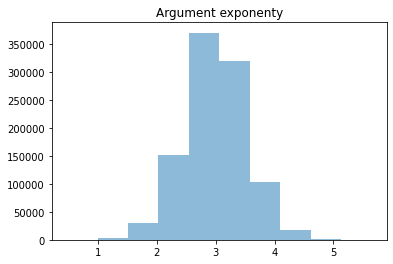

count    1000.000000
mean       22.194905
std        11.123953
min         6.140200
25%        14.133375
50%        19.482700
75%        28.166825
max        65.020000
Name: 0, dtype: float64

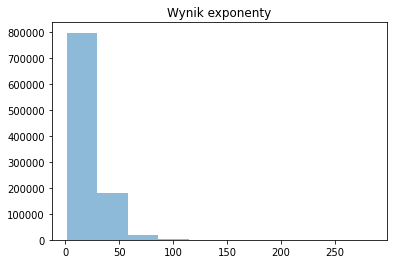

,sigma
count,1000.000000
mean,2.016901
std,2.076713
min,0.001338
25%,0.541990
50%,1.319255
75%,2.765280
max,13.069800


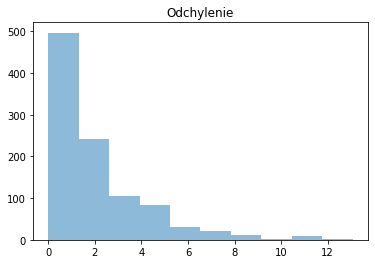

count     1000.000000
mean      4835.081869
std       5148.151112
min        297.695000
25%       1568.645000
50%       2978.990000
75%       6224.382500
max      33158.800000
Name: 0, dtype: float64

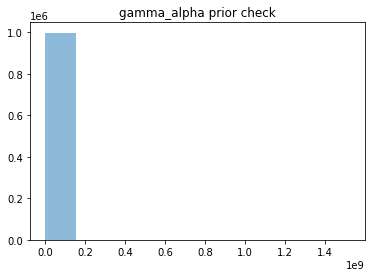

count    1.000000e+03
mean     1.625780e+05
std      2.774570e+05
min      1.821770e+03
25%      2.215603e+04
50%      5.801915e+04
75%      1.752930e+05
max      2.155920e+06
Name: 0, dtype: float64

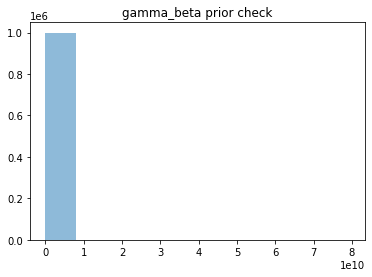

count    1000.000000
mean       22.194960
std        11.124399
min         5.613240
25%        14.126225
50%        19.533200
75%        28.025325
max        65.183600
Name: 0, dtype: float64


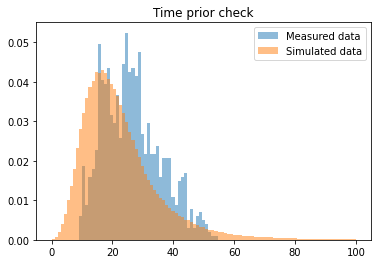

distance_coef      distance_coeff
0         -0.304634
1         -0.065863
2         -0.318020
3          0.062656
4         -0.113063
..              ...
995       -0.138672
996       -0.160918
997        0.315882
998        0.258562
999       -0.064019

[1000 rows x 1 columns]


In [72]:
model_ppc=CmdStanModel(stan_file='norm_ppc.stan')

sim=model_ppc.sample(data={"N": len(train_df), "distance": train_df["Normalized distances"].values,
                           "meal_preparation_time": train_df["Normalized mealprep"].values,
                           "traffic_level" :train_df["Road_traffic_density"].values}, 
                     iter_sampling=1000,
                     iter_warmup=0, 
                     chains=1, 
                     fixed_param=True,
                     seed=20230613)
ppc_df = sim.draws_pd()

bins = np.linspace(0,100,100)

mean_for_gamma = ppc_df.filter(regex="temp1.*")

delivery = ppc_df.filter(regex="delivery_time.*")
display(mean_for_gamma.iloc[0,:].describe())
# delivery.iloc[:,:].apply(pd.DataFrame.describe, axis=1)
# delivery['value'].describe()
# display(speed.loc[0,:].min())
plt.hist(mean_for_gamma.values.flatten(), alpha=0.5, label="Mu")
plt.title("Argument exponenty")
plt.show()

# mean_for_gamma = ppc_df.filter(regex="temp2.*")

# delivery = ppc_df.filter(regex="delivery_time.*")
# display(mean_for_gamma.iloc[0,:].describe())
# # delivery.iloc[:,:].apply(pd.DataFrame.describe, axis=1)
# # delivery['value'].describe()
# # display(speed.loc[0,:].min())
# plt.hist(mean_for_gamma.values.flatten(), alpha=0.5, label="Mu")
# plt.title("Exponenta bez dodawania meal prepa")
# plt.show()

mean_for_gamma1 = ppc_df.filter(regex="mu.*")

# delivery = ppc_df.filter(regex="delivery_time.*")
display(mean_for_gamma1.iloc[0,:].describe())
# delivery.iloc[:,:].apply(pd.DataFrame.describe, axis=1)
# delivery['value'].describe()
# display(speed.loc[0,:].min())
plt.hist(mean_for_gamma1.values.flatten(), alpha=0.5, label="Mu")
plt.title("Wynik exponenty")
plt.show()

# sigma = ppc_df.filter(regex="sigma.*")
# print(f"Odchylenie =  {sigma.values}")

sigma = ppc_df.filter(regex="sigma.*")

# delivery = ppc_df.filter(regex="delivery_time.*")
display(sigma.iloc[:,:].describe())
# delivery.iloc[:,:].apply(pd.DataFrame.describe, axis=1)
# delivery['value'].describe()
# display(speed.loc[0,:].min())
plt.hist(sigma.values.flatten(), alpha=0.5, label="sigma")
plt.title("Odchylenie")
plt.show()

# sigma = ppc_df.filter(regex="distance_coeff.*")
# print(f"Wsp odległości =  {sigma.values}")

# sigma = ppc_df.filter(regex="meal_prep_coeff.*")
# print(f"Wsp przygotowania posiłku =  {sigma.values}")

mean_for_gamma2 = ppc_df.filter(regex="gamma_alpha.*")
# delivery = ppc_df.filter(regex="delivery_time.*")
display(mean_for_gamma2.iloc[0,:].describe())
# delivery.iloc[:,:].apply(pd.DataFrame.describe, axis=1)
# delivery['value'].describe()
# display(speed.loc[0,:].min())
plt.hist(mean_for_gamma2.values.flatten(), alpha=0.5, label="Mu")
plt.title("gamma_alpha prior check")
plt.show()

mean_for_gamma3 = ppc_df.filter(regex="gamma_beta.*")
# delivery = ppc_df.filter(regex="delivery_time.*")
display(mean_for_gamma3.iloc[0,:].describe())
# delivery.iloc[:,:].apply(pd.DataFrame.describe, axis=1)
# delivery['value'].describe()
# display(speed.loc[0,:].min())
plt.hist(mean_for_gamma3.values.flatten(), alpha=0.5, label="Mu")
plt.title("gamma_beta prior check")
plt.show()

print(delivery.iloc[0,:].describe())
plt.hist(train_df["Time_taken(min)"],bins=bins ,alpha=0.5, label="Measured data", density=True)
plt.hist(delivery.values.flatten(),bins=bins, alpha=0.5, label="Simulated data", density=True)
plt.title("Time prior check")
plt.legend()
plt.show()


print(f"distance_coef {ppc_df.filter(regex='distance_coeff.*')}")

INFO:cmdstanpy:compiling stan file /home/project_repo/data_analytics_project/norm_fit.stan to exe file /home/project_repo/data_analytics_project/norm_fit
INFO:cmdstanpy:compiled model executable: /home/project_repo/data_analytics_project/norm_fit
INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |▍         | 00:00 Status


chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:00 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:01 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:01 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:01 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:01 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:01 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     


INFO:cmdstanpy:CmdStan done processing.


,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,distance_coeff,traffic_level_coeff[1],traffic_level_coeff[2],...,log_lik[991],log_lik[992],log_lik[993],log_lik[994],log_lik[995],log_lik[996],log_lik[997],log_lik[998],log_lik[999],log_lik[1000]
0,-3549.30,1.000000,0.612702,3.0,7.0,0.0,3556.24,-0.004389,0.428988,0.337200,...,-3.35861,-2.93007,-3.33385,-2.99414,-4.01607,-2.89193,-2.86887,-3.76225,-3.47980,-3.07526
1,-3551.26,0.631668,0.612702,3.0,7.0,0.0,3557.49,0.012128,0.435115,0.302278,...,-3.32300,-2.82372,-3.40365,-2.92525,-4.02996,-2.81054,-2.79844,-3.66808,-3.58240,-2.98915
2,-3551.44,0.857841,0.612702,3.0,7.0,0.0,3556.27,-0.003898,0.389080,0.320289,...,-3.32096,-2.91638,-3.26669,-2.94830,-4.14355,-2.90177,-2.83748,-3.82864,-3.44914,-3.05295
3,-3551.31,0.988473,0.612702,3.0,7.0,0.0,3557.87,-0.006091,0.417161,0.304357,...,-3.38046,-2.94007,-3.25784,-2.95496,-4.03802,-2.92744,-2.85853,-3.74203,-3.45220,-3.05010
4,-3550.55,1.000000,0.612702,3.0,7.0,0.0,3552.97,0.020867,0.420603,0.327198,...,-3.34778,-2.85110,-3.49609,-2.99346,-4.14015,-2.81805,-2.83635,-3.81039,-3.57925,-3.07718
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,-3547.53,1.000000,0.549168,3.0,7.0,0.0,3550.36,0.008575,0.423951,0.303721,...,-3.41910,-2.86019,-3.45940,-2.95674,-4.07266,-2.81666,-2.84120,-3.79474,-3.55038,-3.05499
3996,-3547.46,0.973346,0.549168,3.0,7.0,0.0,3549.97,0.012566,0.414563,0.281401,...,-3.44160,-2.89084,-3.35760,-2.93824,-4.12317,-2.87714,-2.83546,-3.79431,-3.47519,-3.05858
3997,-3547.42,0.990290,0.549168,3.0,7.0,0.0,3548.98,0.004936,0.415542,0.299984,...,-3.35861,-2.87694,-3.32854,-2.93808,-4.08341,-2.87148,-2.82914,-3.73920,-3.52216,-3.03554
3998,-3547.92,0.924028,0.549168,3.0,7.0,0.0,3550.68,0.018494,0.418646,0.326779,...,-3.38148,-2.87061,-3.46192,-2.98587,-4.13062,-2.82192,-2.82758,-3.86573,-3.44571,-3.06094


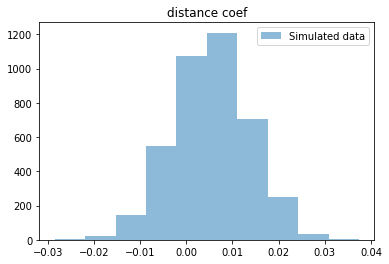

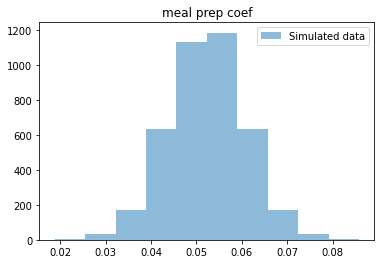

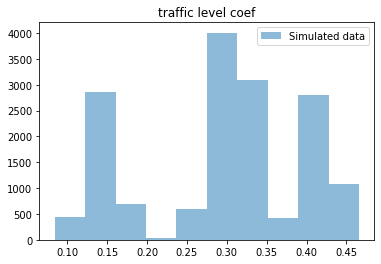

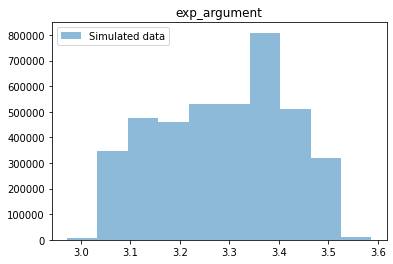

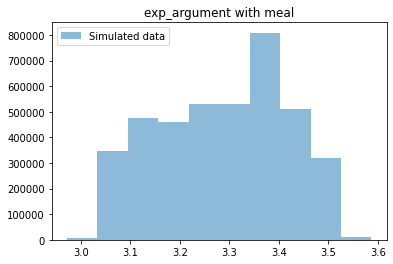

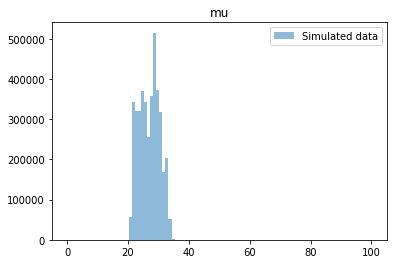

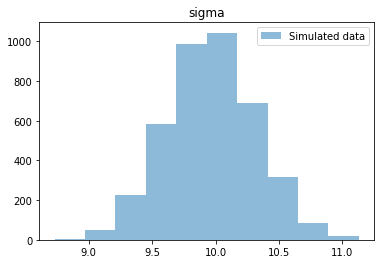

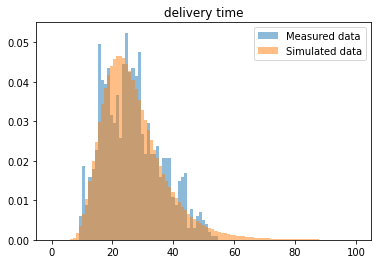

In [73]:
basic_fit=CmdStanModel(stan_file='norm_fit.stan')

basic_sample=basic_fit.sample(data={"N": len(train_df), 
                                    "distance": train_df["Normalized distances"].values,
                                    "meal_preparation_time": train_df["Normalized mealprep"].values, 
                                    "delivery_times": train_df["Time_taken(min)"].values, 
                                    "traffic_level" :train_df["Road_traffic_density"].values},
                     iter_sampling=1000,
                     iter_warmup=1000, 
                     chains=4,
                         )


df_fit = basic_sample.draws_pd()
display(df_fit)

traffib_level = df_fit.filter(regex="distance_coef.*")
# df_fit.iloc[:, 8:]
# plt.hist(train_df["Time_taken(min)"], bins=bins, alpha=0.5, label="Measured data")
plt.hist(traffib_level.values.flatten(), alpha=0.5, label="Simulated data")
plt.title("distance coef")
plt.legend()
plt.show()

traffib_level = df_fit.filter(regex="meal_prep_coef.*")
# df_fit.iloc[:, 8:]
# plt.hist(train_df["Time_taken(min)"], bins=bins, alpha=0.5, label="Measured data")
plt.hist(traffib_level.values.flatten(), alpha=0.5, label="Simulated data")
plt.title("meal prep coef")
plt.legend()
plt.show()


traffib_level = df_fit.filter(regex="traffic_level_coef.*")
# df_fit.iloc[:, 8:]
# plt.hist(train_df["Time_taken(min)"], bins=bins, alpha=0.5, label="Measured data")
plt.hist(traffib_level.values.flatten(), alpha=0.5, label="Simulated data")
plt.title("traffic level coef")
plt.legend()
plt.show()

epx_argument = df_fit.filter(regex="exp_argument.*")
# df_fit.iloc[:, 8:]
# plt.hist(train_df["Time_taken(min)"], bins=bins, alpha=0.5, label="Measured data")
plt.hist(epx_argument.values.flatten(), alpha=0.5, label="Simulated data")
plt.title("exp_argument")
plt.legend()
plt.show()

epx_argument = df_fit.filter(regex="exp_argument_with.*")
# df_fit.iloc[:, 8:]
# plt.hist(train_df["Time_taken(min)"], bins=bins, alpha=0.5, label="Measured data")
plt.hist(epx_argument.values.flatten(), alpha=0.5, label="Simulated data")
plt.title("exp_argument with meal")
plt.legend()
plt.show()

mu = df_fit.filter(regex="mu.*")
# df_fit.iloc[:, 8:]
# plt.hist(train_df["Time_taken(min)"], bins=bins, alpha=0.5, label="Measured data")
plt.hist(mu.values.flatten(),bins=bins, alpha=0.5, label="Simulated data")
plt.title("mu")
plt.legend()
plt.show()

# travel_time = df_fit.filter(regex="travel_time.*")
# # df_fit.iloc[:, 8:]
# # plt.hist(train_df["Time_taken(min)"], bins=bins, alpha=0.5, label="Measured data")
# plt.hist(travel_time.values.flatten(),bins=np.linspace(0,100,100), alpha=0.5, label="Simulated data")
# plt.title("travel time")
# plt.legend()
# plt.show()

sigma = df_fit.filter(regex="sigma.*")
# df_fit.iloc[:, 8:]
# plt.hist(train_df["Time_taken(min)"], bins=bins, alpha=0.5, label="Measured data")
plt.hist(sigma.values.flatten(), alpha=0.5, label="Simulated data")
plt.title("sigma")
plt.legend()
plt.show()



delivery_fit = df_fit.filter(regex="delivery_time.*")
# df_fit.iloc[:, 8:]
plt.hist(train_df["Time_taken(min)"], bins=bins,density=True, alpha=0.5, label="Measured data")
plt.hist(delivery_fit.values.flatten(),bins=bins,density=True, alpha=0.5, label="Simulated data")
plt.title("delivery time")
plt.legend()
plt.show()

# print(f"meal_prep_ceof {df_fit.filter(regex='meal_prep_coef.*')}")
# print(f"distance_coef {df_fit.filter(regex='distance_coeff.*')}")
temp=basic_sample.diagnose()
with open("output.txt", "w") as file:
    file.write(temp)

In [74]:

display(mu.values.flatten().min())

19.5334

# Model 2

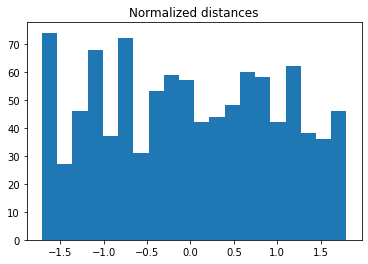

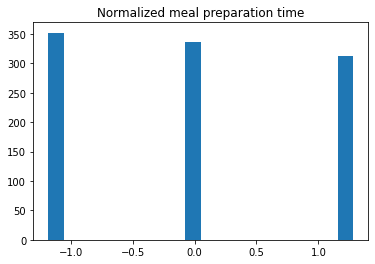

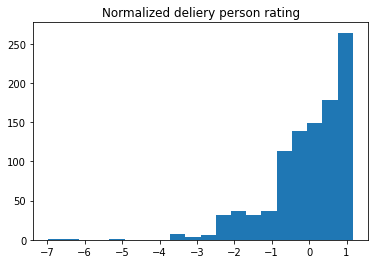

9.305280999999999
26.747
4.6414


In [75]:
train_df["Normalized person_rating"] = (train_df["Delivery_person_Ratings"] - train_df["Delivery_person_Ratings"].mean()) / train_df["Delivery_person_Ratings"].std()

# train_df = train_df[train_df["Mean speed"] < 1.7]
plt.hist(train_df["Normalized distances"], bins=20)
plt.title("Normalized distances")
plt.show()

plt.hist(train_df["Normalized mealprep"], bins=20)
plt.title("Normalized meal preparation time")
plt.show()

plt.hist(train_df["Normalized person_rating"], bins=20)
plt.title("Normalized deliery person rating")
plt.show()

print(train_df["Road distances [km]"].mean())
print(train_df["Time_taken(min)"].mean())
print(train_df["Delivery_person_Ratings"].mean())


train_df["multiple_deliveries"] = train_df["multiple_deliveries"]+1


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start processing
chain 1 |██████████| 00:01 Sampling completed                      


INFO:cmdstanpy:CmdStan done processing.


,temp1[1],temp1[2],temp1[3],temp1[4],temp1[5],temp1[6],temp1[7],temp1[8],temp1[9],temp1[10],...,temp1[991],temp1[992],temp1[993],temp1[994],temp1[995],temp1[996],temp1[997],temp1[998],temp1[999],temp1[1000]
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,...,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,3.033509,2.993303,3.001527,3.018866,2.999299,2.995320,3.013607,2.987538,3.000793,3.011949,...,3.007015,2.995591,2.989592,3.007608,3.003122,2.991313,2.977963,2.985992,2.978531,2.995926
std,0.722122,0.721491,0.433970,0.593301,0.441977,0.771941,0.424958,0.644760,0.842035,0.846770,...,0.653253,0.499245,0.762377,0.560763,0.580695,0.598886,0.567999,0.763553,0.865394,0.671292
min,0.540999,0.983202,1.269530,1.106290,1.680800,0.696624,1.605340,0.919451,-0.199918,-0.168895,...,0.745529,1.277990,0.344013,0.678192,1.318890,0.627396,1.061460,0.461016,0.287820,0.876736
25%,2.563115,2.500750,2.732620,2.635013,2.711982,2.494560,2.730125,2.554067,2.486568,2.452865,...,2.543930,2.675130,2.474965,2.640780,2.593535,2.585345,2.588248,2.518468,2.385020,2.547477
50%,3.046340,3.010380,2.997650,3.030720,2.978980,3.012620,3.023695,2.971325,2.982785,3.004115,...,2.994880,3.000425,2.994265,3.008385,3.000670,2.974430,2.982110,2.986855,3.012550,2.984390
75%,3.506373,3.514535,3.290680,3.410875,3.305635,3.504315,3.303225,3.420165,3.563502,3.578628,...,3.459160,3.332915,3.486242,3.386135,3.393167,3.405842,3.365082,3.474305,3.545153,3.449945
max,5.274990,5.387930,4.359680,5.456100,4.593470,5.491940,4.112940,5.200360,5.691500,5.811760,...,5.116070,4.645940,5.298890,4.757660,5.126160,4.841960,4.461970,5.313100,6.277280,5.336840


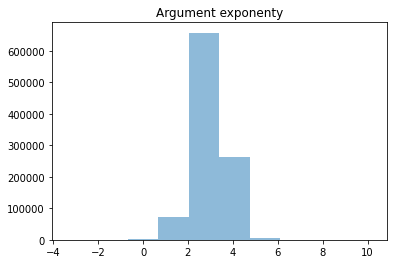

count    1000.000000
mean       25.103484
std        15.411042
min         0.444313
25%        14.041600
50%        21.626350
75%        33.437200
max       106.076000
Name: 0, dtype: float64

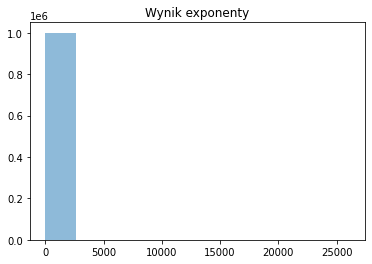

,sigma
count,1000.000000
mean,1.963928
std,1.977101
min,0.001890
25%,0.511429
50%,1.379890
75%,2.863960
max,16.721100


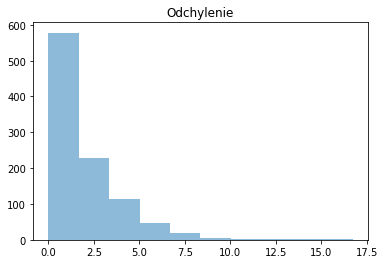

,person_rating_coeff
count,1000.000000
mean,0.008836
std,0.291868
min,-0.923857
25%,-0.189868
50%,0.011091
75%,0.204434
max,0.878167


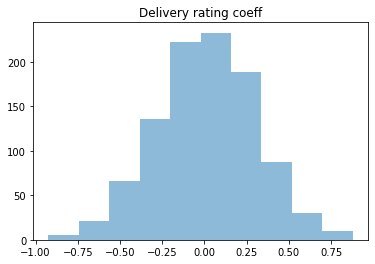

count    1000.000000
mean       25.072807
std        15.464660
min         0.549849
25%        13.626800
50%        21.606750
75%        33.673050
max       105.689000
Name: 0, dtype: float64


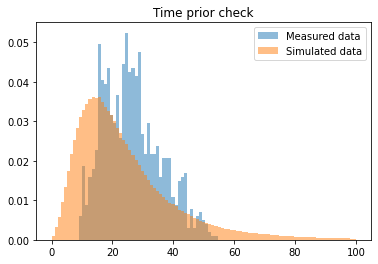

distance_coef      distance_coeff
0         -0.304634
1         -0.123962
2         -0.073750
3         -0.305913
4         -0.633559
..              ...
995       -0.398232
996       -0.274794
997        0.296456
998       -0.308612
999        0.265084

[1000 rows x 1 columns]


In [76]:
model_ppc=CmdStanModel(stan_file='model2_ppc.stan')

sim=model_ppc.sample(data={"N": len(train_df), "distance": train_df["Normalized distances"].values,
                           "meal_preparation_time": train_df["Normalized mealprep"].values,
                           "traffic_level": train_df["Road_traffic_density"].values,
                           "delivery_person_rating": train_df["Normalized person_rating"].values,
                           "number_of_deliveiers": train_df["multiple_deliveries"].values}, 
                     iter_sampling=1000,
                     iter_warmup=0, 
                     chains=1, 
                     fixed_param=True,
                     seed=20230613)
ppc_df = sim.draws_pd()

bins = np.linspace(0,100,100)

mean_for_gamma = ppc_df.filter(regex="temp1.*")

delivery = ppc_df.filter(regex="delivery_time.*")
display(mean_for_gamma.iloc[:,:].describe())
# delivery.iloc[:,:].apply(pd.DataFrame.describe, axis=1)
# delivery['value'].describe()
# display(speed.loc[0,:].min())
plt.hist(mean_for_gamma.values.flatten(), alpha=0.5, label="Mu")
plt.title("Argument exponenty")
plt.show()

# mean_for_gamma = ppc_df.filter(regex="temp2.*")

# delivery = ppc_df.filter(regex="delivery_time.*")
# display(mean_for_gamma.iloc[0,:].describe())
# # delivery.iloc[:,:].apply(pd.DataFrame.describe, axis=1)
# # delivery['value'].describe()
# # display(speed.loc[0,:].min())
# plt.hist(mean_for_gamma.values.flatten(), alpha=0.5, label="Mu")
# plt.title("Exponenta bez dodawania meal prepa")
# plt.show()

mean_for_gamma1 = ppc_df.filter(regex="mu.*")

# delivery = ppc_df.filter(regex="delivery_time.*")
display(mean_for_gamma1.iloc[0,:].describe())
# delivery.iloc[:,:].apply(pd.DataFrame.describe, axis=1)
# delivery['value'].describe()
# display(speed.loc[0,:].min())
plt.hist(mean_for_gamma1.values.flatten(), alpha=0.5, label="Mu")
plt.title("Wynik exponenty")
plt.show()

# sigma = ppc_df.filter(regex="sigma.*")
# print(f"Odchylenie =  {sigma.values}")

sigma = ppc_df.filter(regex="sigma.*")

# delivery = ppc_df.filter(regex="delivery_time.*")
display(sigma.iloc[:,:].describe())
# delivery.iloc[:,:].apply(pd.DataFrame.describe, axis=1)
# delivery['value'].describe()
# display(speed.loc[0,:].min())
plt.hist(sigma.values.flatten(), alpha=0.5, label="sigma")
plt.title("Odchylenie")
plt.show()

sigma = ppc_df.filter(regex="person_rating_coeff.*")

# delivery = ppc_df.filter(regex="delivery_time.*")
display(sigma.iloc[:,:].describe())
# delivery.iloc[:,:].apply(pd.DataFrame.describe, axis=1)
# delivery['value'].describe()
# display(speed.loc[0,:].min())
plt.hist(sigma.values.flatten(), alpha=0.5, label="sigma")
plt.title("Delivery rating coeff")
plt.show()

# sigma = ppc_df.filter(regex="distance_coeff.*")
# print(f"Wsp odległości =  {sigma.values}")

# sigma = ppc_df.filter(regex="meal_prep_coeff.*")
# print(f"Wsp przygotowania posiłku =  {sigma.values}")

# mean_for_gamma2 = ppc_df.filter(regex="gamma_alpha.*")
# # delivery = ppc_df.filter(regex="delivery_time.*")
# display(mean_for_gamma2.iloc[0,:].describe())
# # delivery.iloc[:,:].apply(pd.DataFrame.describe, axis=1)
# # delivery['value'].describe()
# # display(speed.loc[0,:].min())
# plt.hist(mean_for_gamma2.values.flatten(), alpha=0.5, label="Mu")
# plt.title("gamma_alpha prior check")
# plt.show()

# mean_for_gamma3 = ppc_df.filter(regex="gamma_beta.*")
# # delivery = ppc_df.filter(regex="delivery_time.*")
# display(mean_for_gamma3.iloc[0,:].describe())
# # delivery.iloc[:,:].apply(pd.DataFrame.describe, axis=1)
# # delivery['value'].describe()
# # display(speed.loc[0,:].min())
# plt.hist(mean_for_gamma3.values.flatten(), alpha=0.5, label="Mu")
# plt.title("gamma_beta prior check")
# plt.show()

print(delivery.iloc[0,:].describe())
plt.hist(train_df["Time_taken(min)"],bins=bins ,alpha=0.5, label="Measured data", density=True)
plt.hist(delivery.values.flatten(),bins=bins, alpha=0.5, label="Simulated data", density=True)
plt.title("Time prior check")
plt.legend()
plt.show()


print(f"distance_coef {ppc_df.filter(regex='distance_coeff.*')}")

INFO:cmdstanpy:compiling stan file /home/project_repo/data_analytics_project/model2_fit.stan to exe file /home/project_repo/data_analytics_project/model2_fit
INFO:cmdstanpy:compiled model executable: /home/project_repo/data_analytics_project/model2_fit
INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▍         | 00:00 Status


chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:01 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:02 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:03 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:05 Iteration:  400 / 2000 [ 20%]  (Warmup)



chain 1 |███▏      | 00:06 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:07 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:09 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:10 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |████


INFO:cmdstanpy:CmdStan done processing.


,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,distance_coeff,traffic_level_coeff[1],traffic_level_coeff[2],...,log_lik[991],log_lik[992],log_lik[993],log_lik[994],log_lik[995],log_lik[996],log_lik[997],log_lik[998],log_lik[999],log_lik[1000]
0,-3387.26,0.802998,0.072235,6.0,127.0,0.0,3390.46,0.006322,0.484959,0.409140,...,-3.11764,-2.73907,-3.23698,-2.83392,-4.35313,-2.67666,-2.82980,-3.42911,-3.02577,-2.87833
1,-3386.91,0.962389,0.072235,6.0,127.0,0.0,3391.48,-0.010123,0.425591,0.350969,...,-2.99056,-2.72530,-3.10189,-2.79932,-4.23366,-2.66223,-2.87950,-3.21814,-3.07695,-2.88093
2,-3387.84,0.977997,0.072235,6.0,63.0,0.0,3391.33,0.010069,0.485907,0.385346,...,-3.16769,-2.72792,-3.20372,-2.78160,-4.39280,-2.64842,-2.83130,-3.45043,-2.94918,-2.83786
3,-3388.01,0.819133,0.072235,6.0,63.0,0.0,3392.71,-0.002080,0.437390,0.396301,...,-2.96346,-2.75888,-3.06421,-2.81045,-4.32071,-2.66780,-3.00463,-3.27246,-2.96013,-2.87326
4,-3388.99,0.997261,0.072235,5.0,31.0,0.0,3391.82,-0.006109,0.464660,0.397809,...,-2.96228,-2.69391,-3.16777,-2.81054,-4.29599,-2.64470,-2.81255,-3.21585,-3.08552,-2.85258
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,-3388.11,0.656597,0.100060,5.0,31.0,0.0,3395.95,-0.005882,0.489605,0.390226,...,-3.04164,-2.70297,-3.13845,-2.78203,-4.26359,-2.64421,-2.84850,-3.21588,-2.97947,-2.86450
3996,-3387.53,0.969482,0.100060,5.0,55.0,0.0,3394.05,0.008493,0.364979,0.230017,...,-3.19554,-2.76939,-3.15489,-2.81928,-4.24078,-2.66870,-2.89292,-3.35773,-3.00989,-2.87110
3997,-3390.00,0.917954,0.100060,5.0,31.0,0.0,3395.24,0.015776,0.300230,0.191167,...,-3.23594,-2.76677,-3.27860,-2.83116,-4.31485,-2.68924,-2.83299,-3.49975,-3.00752,-2.89516
3998,-3387.17,0.962414,0.100060,3.0,7.0,0.0,3391.41,0.014821,0.301357,0.189652,...,-3.23349,-2.77600,-3.24742,-2.82635,-4.30549,-2.68408,-2.85536,-3.48324,-2.98770,-2.89287


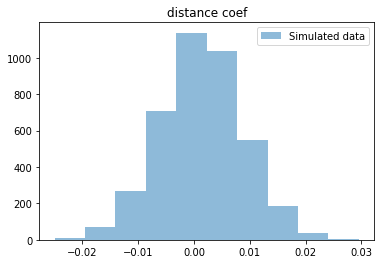

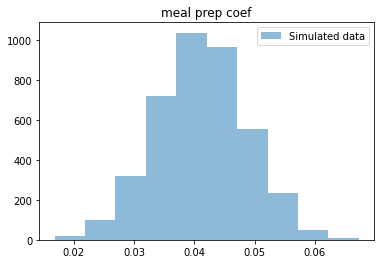

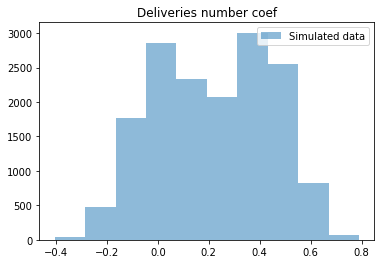

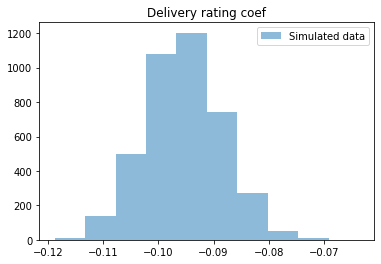

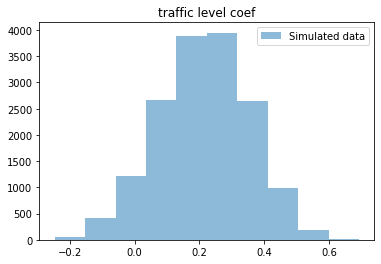

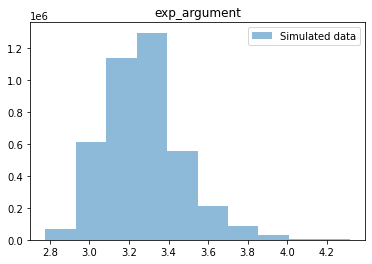

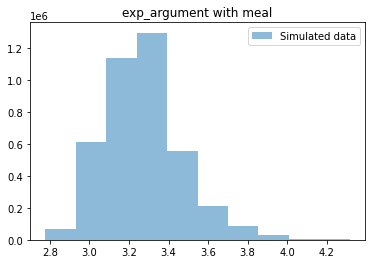

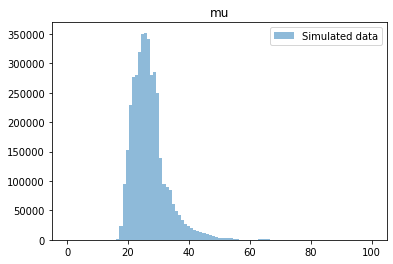

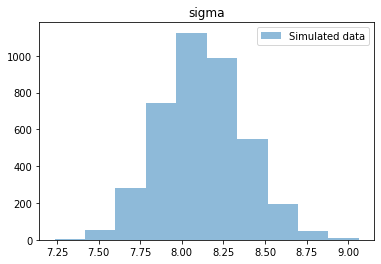

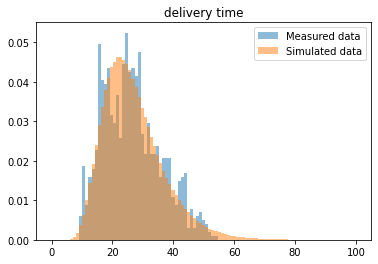

In [77]:
model2_fit=CmdStanModel(stan_file='model2_fit.stan')

model2_sample=model2_fit.sample(data={"N": len(train_df), 
                                    "distance": train_df["Normalized distances"].values,
                                    "meal_preparation_time": train_df["Normalized mealprep"].values, 
                                    "delivery_times": train_df["Time_taken(min)"].values, 
                                    "traffic_level" :train_df["Road_traffic_density"].values,
                                    "delivery_person_rating": train_df["Normalized person_rating"].values,
                                    "number_of_deliveiers": train_df["multiple_deliveries"].values}, 
                     iter_sampling=1000,
                     iter_warmup=1000, 
                     chains=4,
                         )


df_fit = model2_sample.draws_pd()
display(df_fit)

traffib_level = df_fit.filter(regex="distance_coef.*")
# df_fit.iloc[:, 8:]
# plt.hist(train_df["Time_taken(min)"], bins=bins, alpha=0.5, label="Measured data")
plt.hist(traffib_level.values.flatten(), alpha=0.5, label="Simulated data")
plt.title("distance coef")
plt.legend()
plt.show()

traffib_level = df_fit.filter(regex="meal_prep_coef.*")
# df_fit.iloc[:, 8:]
# plt.hist(train_df["Time_taken(min)"], bins=bins, alpha=0.5, label="Measured data")
plt.hist(traffib_level.values.flatten(), alpha=0.5, label="Simulated data")
plt.title("meal prep coef")
plt.legend()
plt.show()

traffib_level = df_fit.filter(regex="deliveries_number_coef.*")
# df_fit.iloc[:, 8:]
# plt.hist(train_df["Time_taken(min)"], bins=bins, alpha=0.5, label="Measured data")
plt.hist(traffib_level.values.flatten(), alpha=0.5, label="Simulated data")
plt.title("Deliveries number coef")
plt.legend()
plt.show()

traffib_level = df_fit.filter(regex="person_rating_coef.*")
# df_fit.iloc[:, 8:]
# plt.hist(train_df["Time_taken(min)"], bins=bins, alpha=0.5, label="Measured data")
plt.hist(traffib_level.values.flatten(), alpha=0.5, label="Simulated data")
plt.title("Delivery rating coef")
plt.legend()
plt.show()


traffib_level = df_fit.filter(regex="traffic_level_coef.*")
# df_fit.iloc[:, 8:]
# plt.hist(train_df["Time_taken(min)"], bins=bins, alpha=0.5, label="Measured data")
plt.hist(traffib_level.values.flatten(), alpha=0.5, label="Simulated data")
plt.title("traffic level coef")
plt.legend()
plt.show()

epx_argument = df_fit.filter(regex="exp_argument.*")
# df_fit.iloc[:, 8:]
# plt.hist(train_df["Time_taken(min)"], bins=bins, alpha=0.5, label="Measured data")
plt.hist(epx_argument.values.flatten(), alpha=0.5, label="Simulated data")
plt.title("exp_argument")
plt.legend()
plt.show()

epx_argument = df_fit.filter(regex="exp_argument_with.*")
# df_fit.iloc[:, 8:]
# plt.hist(train_df["Time_taken(min)"], bins=bins, alpha=0.5, label="Measured data")
plt.hist(epx_argument.values.flatten(), alpha=0.5, label="Simulated data")
plt.title("exp_argument with meal")
plt.legend()
plt.show()

mu = df_fit.filter(regex="mu.*")
# df_fit.iloc[:, 8:]
# plt.hist(train_df["Time_taken(min)"], bins=bins, alpha=0.5, label="Measured data")
plt.hist(mu.values.flatten(),bins=bins, alpha=0.5, label="Simulated data")
plt.title("mu")
plt.legend()
plt.show()

# travel_time = df_fit.filter(regex="travel_time.*")
# # df_fit.iloc[:, 8:]
# # plt.hist(train_df["Time_taken(min)"], bins=bins, alpha=0.5, label="Measured data")
# plt.hist(travel_time.values.flatten(),bins=np.linspace(0,100,100), alpha=0.5, label="Simulated data")
# plt.title("travel time")
# plt.legend()
# plt.show()

sigma = df_fit.filter(regex="sigma.*")
# df_fit.iloc[:, 8:]
# plt.hist(train_df["Time_taken(min)"], bins=bins, alpha=0.5, label="Measured data")
plt.hist(sigma.values.flatten(), alpha=0.5, label="Simulated data")
plt.title("sigma")
plt.legend()
plt.show()



delivery_fit = df_fit.filter(regex="delivery_time.*")
# df_fit.iloc[:, 8:]
plt.hist(train_df["Time_taken(min)"], bins=bins,density=True, alpha=0.5, label="Measured data")
plt.hist(delivery_fit.values.flatten(),bins=bins,density=True, alpha=0.5, label="Simulated data")
plt.title("delivery time")
plt.legend()
plt.show()

# print(f"meal_prep_ceof {df_fit.filter(regex='meal_prep_coef.*')}")
# print(f"distance_coef {df_fit.filter(regex='distance_coeff.*')}")
temp=model2_sample.diagnose()
with open("output2.txt", "w") as file:
    file.write(temp)

# Comparison

In [78]:
model1_az = az.from_cmdstanpy(
    posterior=basic_sample,
)

model2_az = az.from_cmdstanpy(
    posterior=model2_sample,
)

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
model2_1,0,-3389.708655,13.822562,0.000000,0.991496,25.704399,0.000000,False,log
model_1,1,-3547.982027,8.742011,158.273373,0.008504,23.544860,15.623852,False,log


Text(0.5, 1.0, 'Comparison of models with LOO criterion')

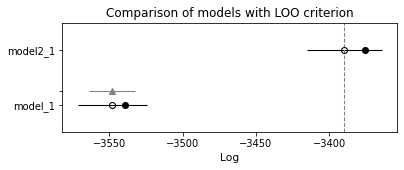

In [79]:
compare_dict = {"model_1": model1_az, "model2_1": model2_az}

loo_diff = az.compare(compare_dict=compare_dict, ic="loo")
display(loo_diff)

ax = az.plot_compare(loo_diff)
ax.set_title("Comparison of models with LOO criterion")

/usr/local/lib/python3.9/site-packages/arviz/stats/stats.py:1635: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/usr/local/lib/python3.9/site-packages/arviz/stats/stats.py:1635: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
model2_1,0,-3389.629722,13.743629,0.000000,0.99144,25.698859,0.000000,True,log
model_1,1,-3547.963981,8.723964,158.334259,0.00856,23.541633,15.622871,True,log


Text(0.5, 1.0, 'Comparison of models with LOO criterion')

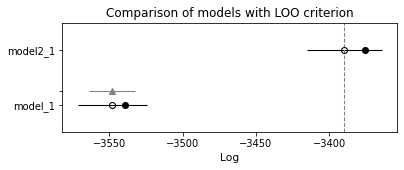

In [80]:
compare_dict = {"model_1": model1_az, "model2_1": model2_az}

loo_diff = az.compare(compare_dict=compare_dict, ic="waic")
display(loo_diff)

ax = az.plot_compare(loo_diff)
ax.set_title("Comparison of models with LOO criterion")

(array([   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
         198.,  402.,  378.,  417.,  395.,  996., 1433., 1399., 1469.,
        1513., 1386., 1342., 1388., 1405., 1415., 1736., 1824., 1701.,
        1667., 1654., 1044., 1048.,  950., 1095., 1004.,  718.,  723.,
         698.,  763.,  734.,  477.,  471.,  487.,  486.,  473.,  209.,
         246.,  252.,  232.,  233.,   60.,   78.,   68.,   79.,   78.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.]),
 array([  0.        ,   1.01010101,   2.02020202,   3.03030303,
          4.04040404,   5.05050505,   6.06060606,   7.07070707,
          8.08080808,   9.09090909,  10.1010101 ,  11.11111111,
         12.12121212,  13

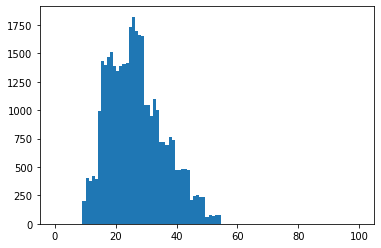

In [85]:
df = pd.read_csv('delivery_time_data.csv', delimiter=';', decimal=',')
plt.hist(df["Time_taken(min)"], bins=bins,)
# plt.hist(train_df["Time_taken(min)"], bins=bins)
# plt.show()